In [1]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
import GMC_util
import pal5_util


ro=8.
#paper on MC used R0=8.5 kpc, using ro=8. as of now.
vo=220.

/home/nil/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

Populating the interactive namespace from numpy and matplotlib


In [2]:
#obtain stream info after combining the pkl files
timpact,apar,x_stream,y_stream,z_stream,_,_,_=GMC_util.aparxv_stream_multiple_pkl(sampling=256,nchunks=16)

#compute impact parameters 
impactMC_ind,M_mc,rs_mc,v_mc,impactb,impact_angle,tmin_low=GMC_util.compute_impact_parameters(timpact,apar,x_stream,y_stream,z_stream)

The stream had 24 impacts


In [ ]:
#load the lower timpact pkl file
with open('pkl_files/pal5pepper_128sampling_MW2014.pkl','rb') as savefile:
            sdf_pepper_128= pickle.load(savefile,encoding='latin1')

sdf_smooth= pal5_util.setup_pal5model()        
#set impacts
sdf_pepper_128.set_impacts(impactb=impactb,subhalovel=v_mc,impact_angle=impact_angle,timpact=tmin_low,rs=rs_mc,GM=M_mc)

In [ ]:
apar=np.arange(0.,1.75,0.01)


densOmega= numpy.array([sdf_pepper_128._densityAndOmega_par_approx(a) for a in apar]).T

dens=densOmega[0]
Omega=densOmega[1]

dens_unp= [sdf_smooth._density_par(a) for a in apar]

In [ ]:
import pal5_util
from scipy import ndimage, signal, interpolate

#with open('Pal5_64impact_MC.pkl','rb') as savefile:
#            sdf_smooth=pickle.load(savefile,encoding='latin1')
#            sdf_pepper= pickle.load(savefile,encoding='latin1')


def convert_dens_to_obs(apars,dens,dens_smooth,mO,sdf_pepper,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(0.25,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))


def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.0001,10.)
    xlim(1,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None

In [ ]:
dat256=np.loadtxt('dens_MC_impact_Pal5_256timpacts.dat')

ll,tdata= convert_dens_to_obs(apar,dens,dens_unp,Omega,sdf_pepper=sdf_pepper_128,poly_deg=3)

plt.figure()
plt.plot(ll,tdata,label='256 on 128')
plt.plot(dat256[:,0],dat256[:,1],label='full 256')

plt.xlabel(r'$\theta_{\parallel}$')
plt.ylabel(r'density/smooth density')
plt.legend(loc='lower right')
plt.savefig('plots/MC_106-107Msun_den_MCs_256timpactsfullvs_on128.pdf'.format(len(timpact)))
plt.show()

# Using impactb,velocity and impact angle of the low resolution, test to see if this produces the same results as the full sdf_pepper


In [6]:
#from the constructed matrices of min_sep and min_apar, compute the min separation for each MC for all timpact
#and the corresponding apar_min, also compute velocity of the MC at that timpact


#
#use timpact_at_min_low to compute (x,v) of MC'

#impactMC_ind,M_mc,rs_mc,v_mc,impactb,impact_angle,tmin_low


#load the GMCs
M,rs,coord=GMC_util.add_MCs()

#integrate their orbits 5 Gyr back,
t_age= np.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(vo,ro)

orbits=[]

N=len(M)

for ii in range(N):

    orbits.append(Orbit(coord[ii]).flip()) # flip flips the velocities for backwards integration
    orbits[ii].integrate(t_age,MWPotential2014)

impactb128=[]
impact_angle128=[]
vx_mc128=[]
vy_mc128=[]
vz_mc128=[]


sdf_smooth= pal5_util.setup_pal5model()
with open('pkl_files/pal5pepper_128sampling_MW2014.pkl','rb') as savefile:
        sdf_pepper_128= pickle.load(savefile,encoding='latin1')

timpact128=sdf_pepper_128._timpact

#print (timpact128)

ap_128,x_128,y_128,z_128,_,_,_= GMC_util.aparxv_stream(sdf_smooth,sdf_pepper_128)



#compute min_sep of each MC
for kk in range(len(tmin_low)):
    
    #find the index in timpact128 at which min sep was reached
    t_ind=list(timpact128).index(tmin_low[kk])
    t128=timpact128[t_ind]
    
    print (t128,tmin_low[kk])
    print (impactMC_ind[kk])
    x_mc=orbits[impactMC_ind[kk]].x(t128)
    y_mc=orbits[impactMC_ind[kk]].y(t128)
    z_mc=orbits[impactMC_ind[kk]].z(t128)
        
    min_sep_128,apar_min_128=GMC_util.compute_min_separation(x_mc,y_mc,z_mc,ap_128[t_ind],x_128[t_ind],y_128[t_ind],z_128[t_ind])
        
    impactb128.append(min_sep_128)
    impact_angle128.append(apar_min_128)
    #flip velocities
    vx_mc128.append(-orbits[impactMC_ind[kk]].vx(t128))
    vy_mc128.append(-orbits[impactMC_ind[kk]].vy(t128))
    vz_mc128.append(-orbits[impactMC_ind[kk]].vz(t128))

v_mc128=np.c_[vx_mc128,vy_mc128,vz_mc128]
        




14.171302287081415 14.171302287081415
35
37.06340598159755 37.06340598159755
44
90.4783146021352 90.4783146021352
64
107.91991741700463 107.91991741700463
94
90.4783146021352 90.4783146021352
95
97.01891565771122 97.01891565771122
125
2.180200351858679 2.180200351858679
161
2.180200351858679 2.180200351858679
162
19.621803166728114 19.621803166728114
184
63.225810203901695 63.225810203901695
205
2.180200351858679 2.180200351858679
231
14.171302287081415 14.171302287081415
274
39.24360633345623 39.24360633345623
283
97.01891565771122 97.01891565771122
284
115.55061864851001 115.55061864851001
298
3.270300527788019 3.270300527788019
299
62.13571002797236 62.13571002797236
300
31.612905101950847 31.612905101950847
312
80.66741301877114 80.66741301877114
316
19.621803166728114 19.621803166728114
334
97.01891565771122 97.01891565771122
339
3.270300527788019 3.270300527788019
342
83.93771354655915 83.93771354655915
344
82.84761337062982 82.84761337062982
352


In [7]:
print (v_mc-v_mc128)

print (np.array(impact_angle)-np.array(impact_angle128))



[[ 1.36285937e-01 -4.63938524e-01  1.61474993e-02]
 [-1.25724543e-01  7.95383883e-02  2.02985001e-03]
 [-2.13426198e-01 -5.06689709e-03  1.88286068e-04]
 [ 1.16907021e-01  4.47612126e-02 -5.18108271e-03]
 [-1.97020589e-01 -1.49061793e-02  1.13980957e-02]
 [-2.38245500e-01 -1.01174932e-01  1.85205717e-02]
 [ 1.00595673e-01 -3.85263302e-01 -4.56455045e-03]
 [ 8.90820515e-02 -3.92533788e-01 -9.06706145e-03]
 [ 4.29134881e-02 -4.87778371e-02 -4.76107442e-03]
 [ 1.31977514e-01 -5.37514781e-02  2.12445115e-03]
 [ 6.66544194e-02 -4.08353863e-01  3.24561430e-03]
 [ 1.22694131e-01 -4.21655505e-01 -2.19477097e-03]
 [ 2.37450034e-01 -2.90376867e-01 -6.07487613e-03]
 [-2.30156105e-01 -1.05869399e-01 -1.03385520e-04]
 [-6.60808187e-02 -3.63846593e-02 -2.00246936e-03]
 [ 5.87649562e-02 -3.95904288e-01  4.97469780e-03]
 [-1.12251642e-01  2.56333222e-02 -1.85156056e-03]
 [-2.21476064e-01  3.01296270e-01  3.79881487e-02]
 [-1.27611167e-01  4.46968529e-03  6.48528390e-04]
 [ 4.77206797e-02 -4.90375193e-

In [9]:
sdf_pepper_128.set_impacts(impactb=impactb128,subhalovel=v_mc128,impact_angle=impact_angle128,timpact=tmin_low,rs=rs_mc,GM=M_mc)

#compute dens in smaller intervals separately and then combine

apar=np.arange(0.,1.75,0.01)


densOmega= numpy.array([sdf_pepper_128._densityAndOmega_par_approx(a) for a in apar]).T

dens=densOmega[0]
Omega=densOmega[1]

dens_unp= [sdf_smooth._density_par(a) for a in apar]

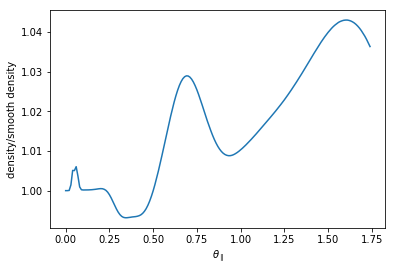

In [10]:
plt.figure()
plt.plot(apar,dens/dens_unp)

plt.xlabel(r'$\theta_{\parallel}$')
plt.ylabel(r'density/smooth density')
#plt.savefig('plots/MC_106-107Msun_den_MCs_{}timpacts.pdf'.format(len(timpact)))
plt.show()

In [ ]:
#write xi dens/dens_smooth out

ll,tdata= convert_dens_to_obs(apar,dens,dens_unp,Omega,poly_deg=3)

fo=open('dens_MC_impact_Pal5_256timpacts_from128sdf_pepper.dat','w')
fo.write('#xi   dens/dens_smooth' + '\n')

for ii in range(len(ll)):
    fo.write(str(ll[ii]) + '   ' + str(tdata[ii]) + '\n')
    
fo.close()

In [ ]:
def compute_Pk(filename=''):
    dat=np.loadtxt(filename)
    ll=dat[:,0]
    tdata=dat[:,1]
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    #return 180./px/numpy.pi, py, py_err #if apars
    
    return (px,py)


f2='dens_MC_impact_Pal5_256timpacts.dat'
f3='dens_MC_impact_Pal5_256timpacts_from128sdf_pepper.dat'



px2,py2=compute_Pk(filename=f2)
px3,py3=compute_Pk(filename=f3)
   


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)


loglog(px2,py2,color='r',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 256 timpact')
loglog(px3,py3,color='b',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 256 timpact on 128sdfpepper')


legend(loc='lower right',fontsize=16)
set_ranges_and_labels_dens()
savefig('power_MC_Pal5_timpact256_compare_256from128sdf_pepper.pdf')